# EXPECTED (40%)
## A custom RESNET

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# For loading popular data sets
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

from torch.utils.data.dataloader import DataLoader

##### Load without Data Augmentation

In [5]:
'''
Normalization - Channel wise mean and standard deviation of the image
'''

# Convert images to Tensor ( Channel X Height X Width)
transform=transforms.Compose([transforms.ToTensor()]) 
                            

# Download training data
train=torchvision.datasets.CIFAR100(root='./data',train=True,download=True,transform=transform)

# Download test data                             
test = torchvision.datasets.CIFAR100(root='./data',train=False,download=True,transform=transform)

# Define validation ratio 
validation_ratio= 0.2
batch_size = 64
train_data,validation_data=torch.utils.data.random_split(train,[int((1-validation_ratio)*len(train)), int((validation_ratio)*len(train))])
print(len(train_data))
print(len(validation_data))

train_loader = DataLoader(train_data, batch_size,pin_memory=True)
val_loader = DataLoader(validation_data, batch_size,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=100,shuffle=False,pin_memory=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
40000
10000


##### Move device to GPU

In [6]:
# Check if your system has cuda gpu or only cpu

def check_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to transfer from CPU to GPU
def move_device(tensor, device):
    
    # Move all individual tensors from cpu to gpu
    if isinstance(tensor, (list,tuple)):
        return [move_device(element, device) for element in tensor]
    return tensor.to(device, non_blocking=True) 

# Execute transfer from CPU to GPU for each device
class DeviceDataLoader():
    
    # Define Constructor
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        
       # Transfer each batch and return
        for i in self.dl: 
            yield move_device(i, self.device)

    def __len__(self):
        
        # Return the number of batches
        return len(self.dl)


device = check_device()

# Move all the tensors to GPU
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

###### Custom ResNet Architecture

In [5]:
class custom_ResNet(nn.Module):
  def __init__(self,input_channel, num_classes):
    super().__init__()

    self.conv_layer_1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,kernel_size= 3,stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
    self.conv_layer_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
    
    self.res_layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
        )
    
    self.conv_layer_3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
    
    self.conv_layer_4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
    
    self.res_layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
        )
    self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                    nn.Flatten(), 
                                    nn.Linear(512*2*2, num_classes))

  def forward(self, xb):
        out = self.conv_layer_1(xb)
        out = self.conv_layer_2(out)
        out = self.res_layer1(out) + out
        out = self.conv_layer_3(out)
        out = self.conv_layer_4(out)
        out = self.res_layer2(out) + out
        out = self.classifier(out)
        return out

model=custom_ResNet(3,100)
print(model)

custom_ResNet(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res_layer1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3)

##### Training

In [9]:
def accuracy(predicted,labels):
    predictions, id=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(id==labels).item()/len(predicted))

# For validation
def evaluate(model,dl,loss_func):
    model.eval()
    loss_per_batch, accuracy_per_batch=[],[]
    for images,labels in valid_dl:
        #start loop
        with torch.no_grad():
            predicted=model(images)
        loss_per_batch.append(loss_func(predicted,labels))
        accuracy_per_batch.append(accuracy(predicted,labels))
    val_loss_epoch=torch.stack(loss_per_batch).mean().item()
    val_accuracy_epoch=torch.stack(accuracy_per_batch).mean().item()
    return val_loss_epoch,val_accuracy_epoch

def train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim):
    
    # Normal optimizer
    #optimizer=optim(model.parameters(), max_lr)
    
    # Applying L2 Regularization
    optimizer=optim(model.parameters(), max_lr,weight_decay=1e-5)
    
    # For SGD
    # optimizer=optim(model.parameters(), max_lr, momentum=0.9,weight_decay=1e-5)
    
    '''
    Learning Rate Scheduler
    '''
    #scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl))
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5,verbose=True)
    #scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)
    
    results=[]
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        train_accuracy_per_batch=[]
        lrs=[]

        for images, labels in train_dl:
            predicted=model(images)
            loss=loss_func(predicted,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
          # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_accuracy_per_batch.append(accuracy(predicted,labels))
    
        scheduler.step()
        epoch_train_acc=torch.stack(train_accuracy_per_batch).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        val_loss_epoch,val_accuracy_epoch=evaluate(model,valid_dl,loss_func)
        
        results.append({'avg_valid_loss': val_loss_epoch,
                        'avg_val_acc': val_accuracy_epoch,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})
        
        print('Number of epochs:', epoch,'|', 
              'Validation loss :',val_loss_epoch, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',val_accuracy_epoch)
    return results


model=move_device(model,device)
epochs = 10

'''
Learning Rates
'''
max_lr1 = 1e-1
max_lr2 = 1e-2
max_lr3 = 1e-3
max_lr4 = 1e-4

loss_func=nn.functional.cross_entropy

'''
Optimizers
'''
#optim=torch.optim.Adam
optim=torch.optim.SGD

'''
Train function call
'''
results1= train(model,train_dl,valid_dl,epochs, max_lr1, loss_func,optim)
results2= train(model,train_dl,valid_dl,epochs, max_lr2, loss_func,optim)
results3= train(model,train_dl,valid_dl,epochs, max_lr3, loss_func,optim)
results4= train(model,train_dl,valid_dl,epochs, max_lr4, loss_func,optim)

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 9.0451e-02.
Number of epochs: 0 | Validation loss : 3.585869073867798  | Training loss : 3.6891467571258545  |   Training accuracy: 0.1304749995470047 validation accuracy : 0.16620223224163055
Adjusting learning rate of group 0 to 6.5451e-02.
Number of epochs: 1 | Validation loss : 3.1567494869232178  | Training loss : 3.1001322269439697  |   Training accuracy: 0.23407499492168427 validation accuracy : 0.2447253167629242
Adjusting learning rate of group 0 to 3.4549e-02.
Number of epochs: 2 | Validation loss : 2.691833972930908  | Training loss : 2.5806643962860107  |   Training accuracy: 0.33922499418258667 validation accuracy : 0.32016322016716003
Adjusting learning rate of group 0 to 9.5492e-03.
Number of epochs: 3 | Validation loss : 2.382085084915161  | Training loss : 2.0880346298217773  |   Training accuracy: 0.447299987077713 validation accuracy : 0.3905254900455475
Adjusting learning rate of

##### Results

In [10]:
'''
Training Accuracy
'''
avg_training_accuracy1=[]
for result in results1:
    avg_training_accuracy1.append(result['avg_train_acc'])

avg_training_accuracy2=[]
for result in results2:
    avg_training_accuracy2.append(result['avg_train_acc'])
    
avg_training_accuracy3=[]
for result in results3:
    avg_training_accuracy3.append(result['avg_train_acc'])
    
avg_training_accuracy4=[]
for result in results4:
    avg_training_accuracy4.append(result['avg_train_acc'])
    

'''
Validation Accuracy
'''
avg_validation_accuracy1=[]
for result in results1:
    avg_validation_accuracy1.append(result['avg_val_acc'])
avg_validation_accuracy2=[]
for result in results2:
    avg_validation_accuracy2.append(result['avg_val_acc'])
avg_validation_accuracy3=[]
for result in results3:
    avg_validation_accuracy3.append(result['avg_val_acc'])
avg_validation_accuracy4=[]
for result in results4:
    avg_validation_accuracy4.append(result['avg_val_acc'])

'''
Validation Loss
'''
avg_validation_loss1=[]
for result in results1:
    avg_validation_loss1.append(result['avg_valid_loss'])
    
avg_validation_loss2=[]
for result in results2:
    avg_validation_loss2.append(result['avg_valid_loss'])
    
avg_validation_loss3=[]
for result in results3:
    avg_validation_loss3.append(result['avg_valid_loss'])
    
avg_validation_loss4=[]
for result in results4:
    avg_validation_loss4.append(result['avg_valid_loss'])


'''
Training Loss
'''
avg_training_loss1=[]
for result in results1:
    avg_training_loss1.append(result['avg_train_loss'])

avg_training_loss2=[]
for result in results2:
    avg_training_loss2.append(result['avg_train_loss'])
    
avg_training_loss3=[]
for result in results3:
    avg_training_loss3.append(result['avg_train_loss'])

avg_training_loss4=[]
for result in results4:
    avg_training_loss4.append(result['avg_train_loss'])

'''
Epochs count
'''
epoch_count=[]
for i in range(epochs):
  
    epoch_count.append(i)

# BASIC (40%)
##### Find Max Learning Rate

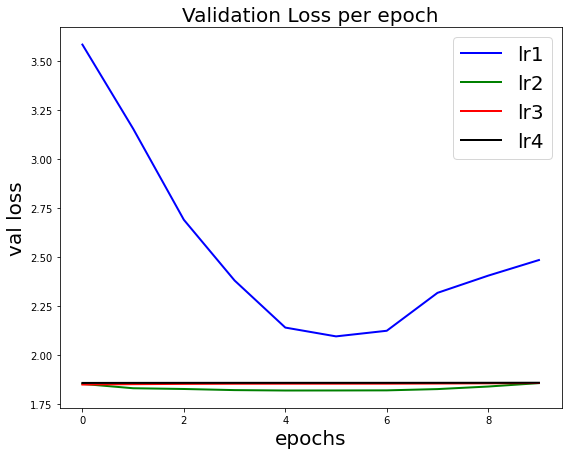

In [27]:
figure(figsize=(9,7))
plt.plot(epoch_count,avg_validation_loss1, 'b', label = "lr1",linewidth = '2')
plt.plot(epoch_count,avg_validation_loss2, 'green', label = "lr2", linewidth = '2')
plt.plot(epoch_count,avg_validation_loss3, 'red', label = "lr3", linewidth = '2')
plt.plot(epoch_count,avg_validation_loss4, 'black', label = "lr4", linewidth = '2')
plt.title("Validation Loss per epoch",fontsize=20)
plt.xlabel("epochs",fontsize=20)  
plt.ylabel("val loss",fontsize=20)
plt.legend(fontsize=20)
plt.show()

##### Graph for Training Loss/epoch for Different Learning Rates

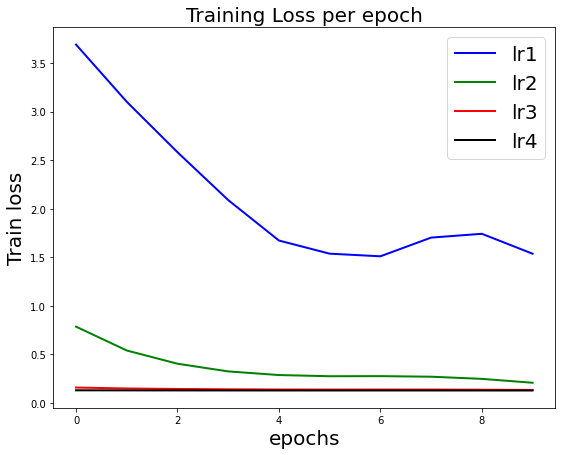

In [29]:
figure(figsize=(9,7))
plt.plot(epoch_count,avg_training_loss1, 'b', label = "lr1",linewidth = '2')
plt.plot(epoch_count,avg_training_loss2, 'g', label = "lr2", linewidth = '2')
plt.plot(epoch_count,avg_training_loss3, 'r', label = "lr3", linewidth = '2')
plt.plot(epoch_count,avg_training_loss4, 'black', label = "lr4", linewidth = '2')
plt.title("Training Loss per epoch",fontsize=20)
plt.xlabel("epochs",fontsize=20)  
plt.ylabel("Train loss",fontsize=20)
plt.legend(fontsize=20)
plt.show()

##### Validation and Training Accuracy per epoch

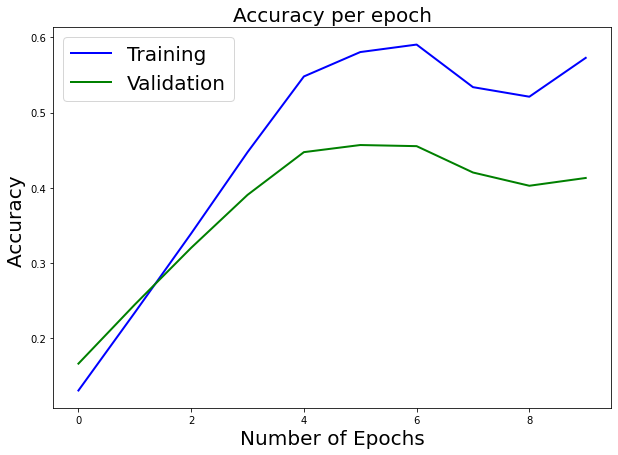

In [21]:
figure(figsize=(10,7))
plt.plot(epoch_count,avg_training_accuracy1, 'b-', label = "Training", linewidth = '2')
plt.plot(epoch_count,avg_validation_accuracy1, 'g-', label = "Validation", linewidth = '2')
plt.title("Accuracy per epoch",fontsize=20)
plt.xlabel("Number of Epochs",fontsize=20)  
plt.ylabel("Accuracy ",fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Testing Accuracy (without Data augmentation and Droput)

In [22]:
model2=custom_ResNet(3,100)
_,test_acc=evaluate(model, test_dl, loss_func)
print(test_acc)


0.5587181448936462


# BASIC (40%)
###  Try different Optimizers

In [7]:
class custom_ResNet(nn.Module):
  def __init__(self,input_channel, num_classes):
    super().__init__()

    self.conv_layer_1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,kernel_size= 3,stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
    self.conv_layer_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
    self.dropout_layer=nn.Dropout(p=0.25)
    
    self.res_layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
        )
    self.dropout_layer=nn.Dropout(p=0.25)
    
    self.conv_layer_3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
    
    self.conv_layer_4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
    self.dropout_layer=nn.Dropout(p=0.25)
    
    self.res_layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
        )
    self.dropout_layer=nn.Dropout(p=0.25)
    self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                    nn.Flatten(), 
                                    nn.Linear(512*2*2, num_classes))

  def forward(self, xb):
        out = self.conv_layer_1(xb)
        out = self.conv_layer_2(out)
        out=self.dropout_layer(out)
        out = self.res_layer1(out) + out
        out=self.dropout_layer(out)
        out = self.conv_layer_3(out)
        out = self.conv_layer_4(out)
        out=self.dropout_layer(out)
        out = self.res_layer2(out) + out
        out=self.dropout_layer(out)
        out = self.classifier(out)
        return out

model=custom_ResNet(3,100)
print(model)

custom_ResNet(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (res_layer1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_layer_3): Sequen

# EXPECTED (40%)
#### Model with Data Augmentation and Regularization

In [8]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.4911, 0.4820, 0.4467),(0.2022, 0.1993, 0.2009)),
                              transforms.RandomCrop(32, padding=4,padding_mode='reflect'), 
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomRotation(2.8),
                              transforms.RandomGrayscale(0.2)                         
                             ])

# Download training data
train = torchvision.datasets.CIFAR100(root='./data',train=True,download=True,transform=transform)
# Download test data                             
test = torchvision.datasets.CIFAR100(root='./data',train=False,download=True)
from torch.utils.data.dataloader import DataLoader
 # Define validation ratio 
validation_ratio= 0.2
batch_size = 32
# split training data in train and validation set
train_data,validation_data=torch.utils.data.random_split(train,[int((1-validation_ratio)*len(train)), int((validation_ratio)*len(train))])
print(len(train_data))
print(len(validation_data))

train_loader = DataLoader(train_data, batch_size,pin_memory=True)
val_loader = DataLoader(validation_data, batch_size,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=100,shuffle=False,pin_memory=True)
                                          
                                          
# Moving to GPU
def check_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to transfer from CPU to GPU
def move_device(tensor, device):
    
    # Move all individual tensors from cpu to gpu
    if isinstance(tensor, (list,tuple)):
        return [move_device(element, device) for element in tensor]
    return tensor.to(device, non_blocking=True) 

# Execute transfer from CPU to GPU for each device
class DeviceDataLoader():
    
    # Define Constructor
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        
       # Transfer each batch and return
        for i in self.dl: 
            yield move_device(i, self.device)

    def __len__(self):
        
        # Return the number of batches
        return len(self.dl)


device = check_device()

# Move all the tensors to GPU
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)


def accuracy(predicted,labels):
    pred, predclassid=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predclassid==labels).item()/len(predicted))


def evaluate(model,dl,loss_func):
    model.eval()
    loss_per_batch, accuracy_per_batch=[],[]
    for images,labels in valid_dl:
        #start loop
        with torch.no_grad():
            predicted=model(images)
        loss_per_batch.append(loss_func(predicted,labels))
        accuracy_per_batch.append(accuracy(predicted,labels))
    val_loss_epoch=torch.stack(loss_per_batch).mean().item()
    val_accuracy_epoch=torch.stack(accuracy_per_batch).mean().item()
    return val_loss_epoch,val_accuracy_epoch

def train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim):
    
    # Normal optimizer
    optimizer=optim(model.parameters(), max_lr)
    
    # Applying L2 Regularization
    #optimizer=optim(model.parameters(), max_lr,weight_decay=1e-5)
    
    # For SGD
    optimizer=optim(model.parameters(), max_lr, momentum=0.9,weight_decay=1e-5)
    
    '''
    Learning Rate Scheduler
    '''
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl))
#     scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5,verbose=True)
#     #scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)
    
    results=[]
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        train_accuracy_per_batch=[]
        lrs=[]

        for images, labels in train_dl:
            predicted=model(images)
            loss=loss_func(predicted,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
          # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_accuracy_per_batch.append(accuracy(predicted,labels))
    
        scheduler.step()
        epoch_train_acc=torch.stack(train_accuracy_per_batch).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        val_loss_epoch,val_accuracy_epoch=evaluate(model,valid_dl,loss_func)
        
        results.append({'avg_valid_loss': val_loss_epoch,
                        'avg_val_acc': val_accuracy_epoch,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})
        
        print('Number of epochs:', epoch,'|', 
              'Validation loss :',val_loss_epoch, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',val_accuracy_epoch)
    return results


model=move_device(model,device)
epochs = 30

'''
Learning Rates
'''
max_lr1 = 1e-1


loss_func=nn.functional.cross_entropy

'''
Optimizers
'''
#optim=torch.optim.Adam
optim=torch.optim.SGD

'''
Train function call
'''
results1= train(model,train_dl,valid_dl,epochs, max_lr1, loss_func,optim)


Files already downloaded and verified
Files already downloaded and verified
40000
10000
Number of epochs: 0 | Validation loss : 4.268755912780762  | Training loss : 5.99457311630249  |   Training accuracy: 0.02734999917447567 validation accuracy : 0.04562699794769287
Number of epochs: 1 | Validation loss : 3.8958728313446045  | Training loss : 4.0522637367248535  |   Training accuracy: 0.08192499727010727 validation accuracy : 0.10043929517269135
Number of epochs: 2 | Validation loss : 3.6166913509368896  | Training loss : 3.7246155738830566  |   Training accuracy: 0.13552500307559967 validation accuracy : 0.14586661756038666
Number of epochs: 3 | Validation loss : 3.3115131855010986  | Training loss : 3.447417974472046  |   Training accuracy: 0.1815750002861023 validation accuracy : 0.19588658213615417
Number of epochs: 4 | Validation loss : 3.090261936187744  | Training loss : 3.196941614151001  |   Training accuracy: 0.22577500343322754 validation accuracy : 0.24101437628269196
Numb

# EXPECTED (40%)
#### Vizualization (with Data Augmentation)

In [9]:
'''
Training Accuracy
'''
avg_training_accuracy1=[]
for result in results1:
    avg_training_accuracy1.append(result['avg_train_acc'])
'''
Validation Accuracy
'''
avg_validation_accuracy1=[]
for result in results1:
    avg_validation_accuracy1.append(result['avg_val_acc'])

'''
Validation Loss
'''
avg_validation_loss1=[]
for result in results1:
    avg_validation_loss1.append(result['avg_valid_loss'])
    
'''
Training Loss
'''
avg_training_loss1=[]
for result in results1:
    avg_training_loss1.append(result['avg_train_loss'])

'''
Epochs count
'''
epoch_count=[]
for i in range(epochs):
    epoch_count.append(i)

##### Training and Validation Accuracy

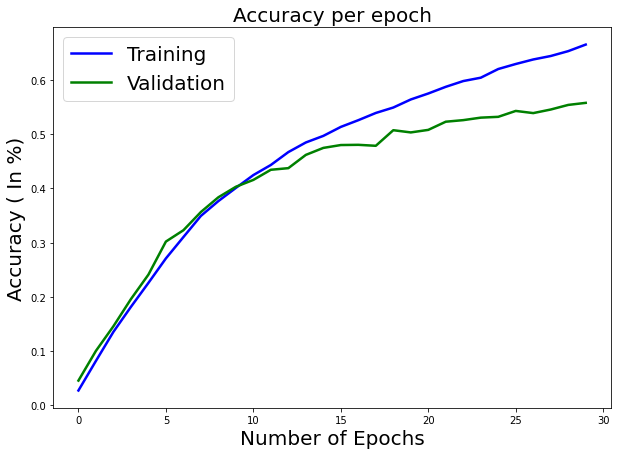

In [10]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.colors as colors

figure(figsize=(10,7))
plt.plot(epoch_count,avg_training_accuracy1, 'b-', label = "Training", linewidth = '2.5')
plt.plot(epoch_count,avg_validation_accuracy1, 'g-', label = "Validation", linewidth = '2.5')
plt.title("Accuracy per epoch",fontsize=20)
plt.xlabel("Number of Epochs",fontsize=20)  
plt.ylabel("Accuracy ( In %)",fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Testing Accuracy

In [11]:
_,test_acc=evaluate(model, test_dl, loss_func)
print('Final Test Accuracy for ResNet : ', test_acc)

Final Test Accuracy for ResNet :  0.5512180328369141
